In [4]:
import warnings
warnings.filterwarnings('ignore')

## Petrophysics calculation

In [5]:
import lasio
las=lasio.read('well-1.las') 

#convert the las file to pandas dataframe, this will automatically retain the logname and made the depth as index column
well=las.df()
print (well)

         CALI       DT      GR    ILD   MSFL  NPHI_LS   RHOB
DEPTH                                                       
3001.0  9.984  148.500  80.875  0.722  0.991  0.43701  2.170
3001.5  9.938  148.625  80.875  0.718  1.026  0.47705  2.176
3002.0  9.914  146.125  80.625  0.714  0.990  0.45947  2.166
3002.5  9.859  145.375  82.625  0.715  0.953  0.47754  2.158
3003.0  9.914  145.125  81.938  0.709  0.900  0.45508  2.156
...       ...      ...     ...    ...    ...      ...    ...
4458.0  8.484  109.000  79.812  1.122  1.744  0.33252  2.316
4458.5  8.469  109.438  82.312  1.112  1.972  0.34082  2.326
4459.0  8.484  109.562  77.188  1.092  1.959  0.35693  2.316
4459.5  8.461  110.750  75.250  1.079  1.746  0.37256  2.311
4460.0  8.469  110.938  75.188  1.067  1.625  0.36768  2.307

[2919 rows x 7 columns]


In [7]:
KujungFM=well.loc[3337.79:3751.5]
print (KujungFM)

         CALI       DT      GR    ILD   MSFL  NPHI_LS   RHOB
DEPTH                                                       
3338.0  8.617  123.625  88.812  1.006  1.292  0.48193  2.264
3338.5  8.562  116.875  79.500  1.182  1.258  0.46924  2.320
3339.0  8.594  100.000  68.562  1.417  1.250  0.37354  2.408
3339.5  8.492   83.938  51.500  1.742  1.430  0.21143  2.562
3340.0  8.297   65.750  33.844  2.174  7.311  0.13428  2.668
...       ...      ...     ...    ...    ...      ...    ...
3749.5  8.555  130.625  85.000  0.773  0.873  0.43115  2.184
3750.0  8.648  130.875  87.500  0.772  0.891  0.43164  2.170
3750.5  8.680  130.875  86.250  0.775  1.158  0.44092  2.178
3751.0  8.727  129.375  89.188  0.773  1.072  0.42285  2.184
3751.5  8.633  129.500  89.688  0.772  1.035  0.40430  2.191

[828 rows x 7 columns]


In [9]:
#this code is adapted from andy mcdonald

def shale_volume(gamma_ray, gamma_ray_max, gamma_ray_min): #specify the arguments
    vshale = (gamma_ray - gamma_ray_min) / (gamma_ray_max - gamma_ray_min) #use the argument to the equation using math operators
    return round(vshale, 4)

def density_porosity(input_density, matrix_density, fluid_density):
    denpor = (matrix_density - input_density) / (matrix_density - fluid_density)
    return round(denpor, 4)

In [10]:
mDens= 2.65
fDens= 1
KujungFM['VSHALE']=shale_volume(KujungFM['GR'], KujungFM['GR'].quantile(q=0.99),
                             KujungFM['GR'].quantile(q=0.01))
KujungFM['PHI']=density_porosity(KujungFM['RHOB'], mDens, fDens)
KujungFM.head()

CALI       DT      GR    ILD   MSFL  NPHI_LS   RHOB  VSHALE     PHI
DEPTH                                                                       
3338.0  8.617  123.625  88.812  1.006  1.292  0.48193  2.264  0.8678  0.2339
3338.5  8.562  116.875  79.500  1.182  1.258  0.46924  2.320  0.7119  0.2000
3339.0  8.594  100.000  68.562  1.417  1.250  0.37354  2.408  0.5289  0.1467
3339.5  8.492   83.938  51.500  1.742  1.430  0.21143  2.562  0.2433  0.0533
3340.0  8.297   65.750  33.844  2.174  7.311  0.13428  2.668 -0.0522 -0.0109

### Calculate RW and SW

**Apparent water formation resistivity using Hingle method**
<img src=https://github.com/partsolco/python-geo-20feb2021/blob/main/images/rw.PNG?raw=true>

**SW:**
<img src=https://github.com/partsolco/python-geo-20feb2021/blob/main/images/sw_archie.png?raw=true>

In [11]:
def rw_app(porosity, archieA, archieM, rt):
    rw= (porosity**archieM*rt/archieA)
    return rw

def sw_archie(porosity, rt, rw, archieA, archieM, archieN):
    sw = ((archieA / (porosity ** archieM)) * (rw/rt))**(1/archieN)
    return sw

archieA= 1
archieM= 2
archieN= 2

In [12]:
KujungFM['rw']=rw_app(KujungFM['NPHI_LS'],archieA,archieM,KujungFM['ILD'])
KujungFM['SW'] = sw_archie(KujungFM['NPHI_LS'],KujungFM['ILD'],KujungFM['rw'],archieA,archieM,archieN)

In [13]:
well.describe()

CALI           DT           GR          ILD         MSFL  \
count  2919.000000  2919.000000  2919.000000  2919.000000  2919.000000   
mean      8.893338   118.309119    74.181216     1.043017     1.556427   
std       0.600544    12.618610    11.396476     0.346950     2.492693   
min       7.629000    57.625000    17.641000     0.533000     0.307000   
25%       8.461000   110.188000    68.500000     0.826000     0.988000   
50%       8.734000   117.812000    76.250000     0.993000     1.275000   
75%       9.242000   126.125000    81.938000     1.214000     1.549000   
max      12.773000   156.250000   101.188000     6.004000    48.177000   

           NPHI_LS         RHOB  
count  2919.000000  2919.000000  
mean      0.380029     2.206859  
std       0.052755     0.092249  
min       0.119630     1.696000  
25%       0.346190     2.174000  
50%       0.380370     2.219000  
75%       0.416020     2.256000  
max       0.523440     2.719000

In [14]:
print(KujungFM.head())

         CALI       DT      GR    ILD   MSFL  NPHI_LS   RHOB  VSHALE     PHI  \
DEPTH                                                                          
3338.0  8.617  123.625  88.812  1.006  1.292  0.48193  2.264  0.8678  0.2339   
3338.5  8.562  116.875  79.500  1.182  1.258  0.46924  2.320  0.7119  0.2000   
3339.0  8.594  100.000  68.562  1.417  1.250  0.37354  2.408  0.5289  0.1467   
3339.5  8.492   83.938  51.500  1.742  1.430  0.21143  2.562  0.2433  0.0533   
3340.0  8.297   65.750  33.844  2.174  7.311  0.13428  2.668 -0.0522 -0.0109   

              rw   SW  
DEPTH                  
3338.0  0.233650  1.0  
3338.5  0.260260  1.0  
3339.0  0.197717  1.0  
3339.5  0.077872  1.0  
3340.0  0.039200  1.0  


## Data Handling

- ***explore the statistical information of the SW and RW log***
- ***compare the mean and the standard deviation of each log from the pandas result***
- ***visualize using histogram, boxplot, etc***

In [15]:
las.set_data(KujungFM)
las.write("kujung.las",version=2.0)

In [20]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

file = 'kujung.las'
data = np.loadtxt(file,skiprows=40)
#this command, convert the ascii file to a num
data[data==-999.2500]=np.nan
print(len(data))
print(data)

826
[[ 3.33900e+03  8.59400e+00  1.00000e+02 ...  1.46700e-01  1.97720e-01
   1.00000e+00]
 [ 3.33950e+03  8.49200e+00  8.39380e+01 ...  5.33000e-02  7.78700e-02
   1.00000e+00]
 [ 3.34000e+03  8.29700e+00  6.57500e+01 ... -1.09000e-02  3.92000e-02
   1.00000e+00]
 ...
 [ 3.75050e+03  8.68000e+00  1.30875e+02 ...  2.86100e-01  1.50670e-01
   1.00000e+00]
 [ 3.75100e+03  8.72700e+00  1.29375e+02 ...  2.82400e-01  1.38210e-01
   1.00000e+00]
 [ 3.75150e+03  8.63300e+00  1.29500e+02 ...  2.78200e-01  1.26190e-01
   1.00000e+00]]


In [22]:
header=['DEPTH','CALI','DT','GR','ILD','MSFL','NPHI','RHOB','VSHALE','PHI','RW','SW']
data=pd.DataFrame(data,columns=header)
#we convert the array to a pandas datafram
print(data)

      DEPTH   CALI       DT      GR    ILD    MSFL     NPHI   RHOB  VSHALE  \
0    3339.0  8.594  100.000  68.562  1.417   1.250  0.37354  2.408  0.5289   
1    3339.5  8.492   83.938  51.500  1.742   1.430  0.21143  2.562  0.2433   
2    3340.0  8.297   65.750  33.844  2.174   7.311  0.13428  2.668 -0.0522   
3    3340.5  8.227   57.625  21.891  2.887  36.021  0.11963  2.719 -0.2523   
4    3341.0  8.227   59.500  17.641  3.887  41.156  0.12842  2.709 -0.3234   
..      ...    ...      ...     ...    ...     ...      ...    ...     ...   
821  3749.5  8.555  130.625  85.000  0.773   0.873  0.43115  2.184  0.8040   
822  3750.0  8.648  130.875  87.500  0.772   0.891  0.43164  2.170  0.8458   
823  3750.5  8.680  130.875  86.250  0.775   1.158  0.44092  2.178  0.8249   
824  3751.0  8.727  129.375  89.188  0.773   1.072  0.42285  2.184  0.8741   
825  3751.5  8.633  129.500  89.688  0.772   1.035  0.40430  2.191  0.8825   

        PHI       RW   SW  
0    0.1467  0.19772  1.0  
1    0.

In [24]:
print('mean for all variables in data: \n'+str(data.mean())+'\n')
print('median for all variables in data: \n'+str(data.median()))

mean for all variables in data: 
DEPTH     3545.250000
CALI         8.588908
DT         118.733051
GR          76.324925
ILD          1.109207
MSFL         1.744936
NPHI         0.381542
RHOB         2.225691
VSHALE       0.658785
PHI          0.257155
RW           0.154451
SW           1.000000
dtype: float64

median for all variables in data: 
DEPTH     3545.250000
CALI         8.535000
DT         119.375000
GR          79.750000
ILD          1.061000
MSFL         1.344500
NPHI         0.387700
RHOB         2.229500
VSHALE       0.716100
PHI          0.254850
RW           0.151965
SW           1.000000
dtype: float64


In [25]:
print('range for all variables in data: \n'+str(data.max()-data.min())+'\n')
print('variance for all variables in data: \n'+str(data.var())+'\n')
print('standard deviation for all variables in data: \n'+str(data.std()))

range for all variables in data: 
DEPTH     412.50000
CALI        2.74200
DT         98.62500
GR         83.54700
ILD         5.44100
MSFL       42.36900
NPHI        0.36670
RHOB        0.84400
VSHALE      1.39830
PHI         0.51150
RW          0.30408
SW          0.00000
dtype: float64

variance for all variables in data: 
DEPTH     14231.291667
CALI          0.115905
DT          148.017596
GR          181.155075
ILD           0.167083
MSFL         10.662063
NPHI          0.002889
RHOB          0.005117
VSHALE        0.050750
PHI           0.001880
RW            0.001021
SW            0.000000
dtype: float64

standard deviation for all variables in data: 
DEPTH     119.294978
CALI        0.340449
DT         12.166248
GR         13.459386
ILD         0.408757
MSFL        3.265281
NPHI        0.053748
RHOB        0.071533
VSHALE      0.225277
PHI         0.043353
RW          0.031947
SW          0.000000
dtype: float64


In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

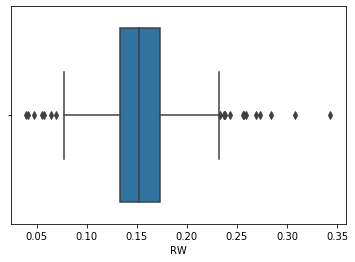

In [30]:
sns.boxplot(data['RW'])
plt.show()

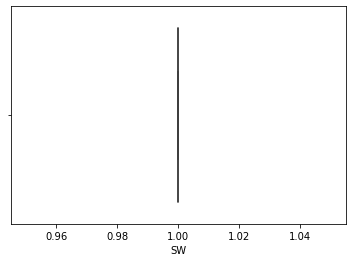

In [31]:
sns.boxplot(data['SW'])
plt.show()

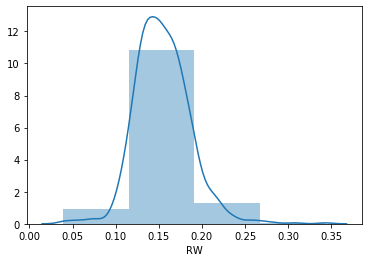

In [38]:
sns.distplot(data['RW'],bins=4)
plt.show()

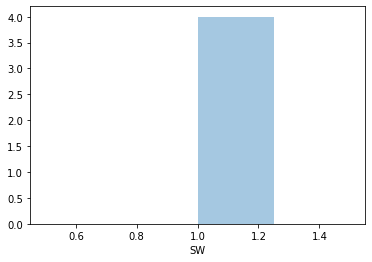

In [39]:
sns.distplot(data['SW'],bins=4)
plt.show()